# AutoTrader Challenge

## Setup

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pyarrow # For accessing parquet files

In [26]:
data_path= f"rate_of_sale_may_2023.snappy.parquet" 

data_dict_path = f"rate_of_sale_data_dict.csv" 

df = pd.read_parquet(data_path) 

category_descriptions = pd.read_csv(data_dict_path) 

In [3]:
df.head(10)

,stock_item_id,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,...,odometer_reading_miles,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality,postcode_area
0,52ae009b671ab58b3d4ff109a9fbdcf8d847de0fa190e1...,2023-05-05,2021-03-25,771,6995,6495.0,False,3.9,Independent,5.0,...,65000,2004-05-07,*IMMACULATE**FULL HISTORY*,False,NOANALYSIS,NaN,NaN,50,NaN,AL
1,32b1bac6934b1f64ff43cffa9df5aa296ead8143c36f9f...,2023-05-09,2021-05-25,714,13725,14995.0,False,NaN,Franchise,5.0,...,16018,2019-11-30,Sports Styling | Great Economy,True,GOOD,14848.0,26078.0,15,57.0,HP
2,21703d22d87eaa95c4dc81a60ba2c8cbe3b90ab659292c...,2023-05-12,2021-11-26,532,15499,13999.0,False,0.2,Independent,5.0,...,31093,2018-03-08,"Sat Nav,Leather,Auto,Euro 6",False,GREAT,14571.0,34732.0,22,61.0,SR
3,661acafc271373946cea7d30ac7f34257404ab89a1ad33...,2023-05-16,2022-02-17,453,10995,9995.0,False,7.9,Franchise,5.0,...,79000,2015-07-02,Viewing by APPOINTMENT ONLY,False,FAIR,9349.0,65684.0,30,61.0,FY
4,638216dc92410d965b416fea5b3cec9ca903368795fdde...,2023-05-04,2022-03-21,409,46000,37500.0,False,6.8,Franchise,5.0,...,10214,2022-03-03,Reserve Online,True,GOOD,37055.0,11765.0,22,48.0,LE
5,e3c8b08856a8736bb48c38f083d42f43f3e3e8e3466610...,2023-05-21,2022-04-27,389,1395,1295.0,False,2.6,Independent,5.0,...,91000,2009-03-25,8 MONTHS MOT,False,NOANALYSIS,2285.0,61512.0,15,NaN,RG
6,82369d8013f2ab13f8f49fb780797298a8dd19974d3b60...,2023-05-14,2022-06-06,342,8257,7457.0,False,NaN,Independent,5.0,...,58849,2015-03-18,"£0 ROAD TAX, 1/2 LEATHER SEATS",False,LOW,8145.0,52450.0,24,54.0,PE
7,1fd13f137d7ed19e993b07dd1708992582537e56efb863...,2023-05-03,2022-06-16,321,23500,19500.0,False,1.2,Independent,5.0,...,40000,2017-11-30,LOW MILEAGE AUTOMATIC,False,NOANALYSIS,24662.0,52255.0,23,44.0,N
8,c34a29671d55abf60ea1ab1c23ad21a0a7437c8ffea756...,2023-05-16,2022-06-23,327,96950,84950.0,False,NaN,Independent,4.0,...,5000,2018-03-29,Mulliner Driving Specification,False,NOANALYSIS,96290.0,23167.0,9,NaN,HP
9,db6f342f73f5c7819fef4254e6886387eac15e026878ab...,2023-05-22,2022-06-24,332,15995,15695.0,False,NaN,Independent,5.0,...,34000,2018-11-07,DEPOSIT TAKEN ON THIS CAR,False,GOOD,15973.0,37233.0,30,65.0,CO


In [4]:
category_descriptions.head(1000)

,Field,Description
0,stock_item_id,Unique ID of the advert e.g. 8a42801e86dad35a0...
1,last_date_seen,The date the vehicle was last seen advertised ...
2,first_date_seen,The first date the vehicle was listed on Auto ...
3,days_to_sell,The difference in days between first_date_seen...
4,first_retailer_asking_price,The price the advert had when first created. T...
5,last_retailer_asking_price,The last seen price
6,can_home_deliver,This advert is able to be delivered to the buy...
7,reviews_per_100_advertised_stock_last_12_months,How many reviews the seller has recieved in th...
8,segment,Whether the seller is a Franchise or Independe...
9,seats,Number of seats in the vehicle


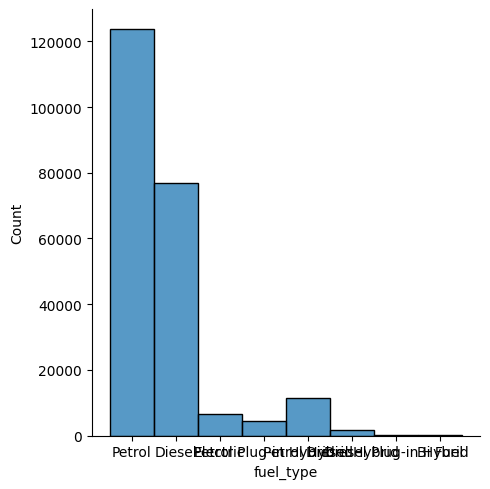

In [6]:
sns.displot(data=df, x='fuel_type')

## Data Sanitisation

### Drop Irrelevant Columns

In [41]:
df = df.drop(columns=['stock_item_id', 'last_date_seen', 'attention_grabber', 'derivative', 'generation', 'derivative_id'])

### Categorical Null Records

In [42]:
length = len(df)

# Drop null records: can_home_deliver
df = df.dropna(subset=['can_home_deliver'])
print(f'{str(length - len(df))} NULL records dropped: can_home_deliver')
length = len(df)

# Drop null records: segment
df = df.dropna(subset=['segment'])
print(f'{str(length - len(df))} NULL records dropped: segment')
length = len(df)

# Drop null records: seats
df = df.dropna(subset=['seats'])
print(f'{str(length - len(df))} NULL records dropped: seats')
length = len(df)

# Drop null records: doors
df = df.dropna(subset=['doors'])
print(f'{str(length - len(df))} NULL records dropped: doors')
length = len(df)

# Drop null records: insurance_group
df = df.dropna(subset=['insurance_group'])
print(f'{str(length - len(df))} NULL records dropped: insurance_group')
length = len(df)

# Drop null records: plate
df = df.dropna(subset=['plate'])
print(f'{str(length - len(df))} NULL records dropped: plate')
length = len(df)

# Drop null records: make
df = df.dropna(subset=['make'])
print(f'{str(length - len(df))} NULL records dropped: make')
length = len(df)

# Drop null records: model
df = df.dropna(subset=['model'])
print(f'{str(length - len(df))} NULL records dropped: model')
length = len(df)

# Drop null records: body_type
df = df.dropna(subset=['body_type'])
print(f'{str(length - len(df))} NULL records dropped: body_type')
length = len(df)

# Drop null records: fuel_type
df = df.dropna(subset=['fuel_type'])
print(f'{str(length - len(df))} NULL records dropped: fuel_type')
length = len(df)

# Drop null records: transmission_type
df = df.dropna(subset=['transmission_type'])
print(f'{str(length - len(df))} NULL records dropped: transmission_type')
length = len(df)

# Drop null records: drivetrain
df = df.dropna(subset=['drivetrain'])
print(f'{str(length - len(df))} NULL records dropped: drivetrain')
length = len(df)

# Drop null records: colour
df = df.dropna(subset=['colour'])
print(f'{str(length - len(df))} NULL records dropped: colour')
length = len(df)

# Drop null records: manufacturer_approved
df = df.dropna(subset=['manufacturer_approved'])
print(f'{str(length - len(df))} NULL records dropped: manufacturer_approved')
length = len(df)

# Drop null records: price_indicator_rating
df = df.dropna(subset=['price_indicator_rating'])
print(f'{str(length - len(df))} NULL records dropped: price_indicator_rating')
length = len(df)

# Drop null records: postcode_area
df = df.dropna(subset=['postcode_area'])
print(f'{str(length - len(df))} NULL records dropped: postcode_area')
length = len(df)


0 NULL records dropped: can_home_deliver
32 NULL records dropped: segment
129 NULL records dropped: seats
3 NULL records dropped: doors
613 NULL records dropped: insurance_group
4 NULL records dropped: plate
0 NULL records dropped: make
0 NULL records dropped: model
0 NULL records dropped: body_type
0 NULL records dropped: fuel_type
0 NULL records dropped: transmission_type
0 NULL records dropped: drivetrain
2027 NULL records dropped: colour
0 NULL records dropped: manufacturer_approved
0 NULL records dropped: price_indicator_rating
0 NULL records dropped: postcode_area


### Continuous Null Records

In [61]:
length = len(df)
cont_cols = ["first_retailer_asking_price", 
             "last_retailer_asking_price", 
             "reviews_per_100_advertised_stock_last_12_months", 
             "co2_emission_gpkm", 
             "top_speed_mph", 
             "engine_power_bhp",
             "fuel_economy_wltp_combined_mpg",
             "advert_quality",
             "number_of_images",
             "predicted_mileage",
             "adjusted_retail_amount_gbp",
             "first_registration_date",
             "odometer_reading_miles",
             "boot_space_seats_up_litres",
             "length_mm"]

In [ ]:

# Drop null records: first_retailer_asking_price
df = df.dropna(subset=['first_retailer_asking_price'])
print(f'{str(length - len(df))} NULL records dropped: first_retailer_asking_price')
length = len(df)

# Drop null records: last_retailer_asking_price
df = df.dropna(subset=['last_retailer_asking_price'])
print(f'{str(length - len(df))} NULL records dropped: last_retailer_asking_price')
length = len(df)

# Drop null records: reviews_per_100_advertised_stock_last_12_months
df = df.dropna(subset=['reviews_per_100_advertised_stock_last_12_months'])
print(f'{str(length - len(df))} NULL records dropped: reviews_per_100_advertised_stock_last_12_months')
length = len(df)

# Drop null records: co2_emission_gpkm
df = df.dropna(subset=['co2_emission_gpkm'])
print(f'{str(length - len(df))} NULL records dropped: co2_emission_gpkm')
length = len(df)

# Drop null records: top_speed_mph
df = df.dropna(subset=['top_speed_mph'])
print(f'{str(length - len(df))} NULL records dropped: top_speed_mph')
length = len(df)

# Drop null records: engine_power_bhp
df = df.dropna(subset=['engine_power_bhp'])
print(f'{str(length - len(df))} NULL records dropped: engine_power_bhp')
length = len(df)

# Drop null records: fuel_economy_wltp_combined_mpg
df = df.dropna(subset=['fuel_economy_wltp_combined_mpg'])
print(f'{str(length - len(df))} NULL records dropped: fuel_economy_wltp_combined_mpg')
length = len(df)

# Drop null records: advert_quality
df = df.dropna(subset=['advert_quality'])
print(f'{str(length - len(df))} NULL records dropped: advert_quality')
length = len(df)

# Drop null records: number_of_images
df = df.dropna(subset=['number_of_images'])
print(f'{str(length - len(df))} NULL records dropped: number_of_images')
length = len(df)

# Drop null records: predicted_mileage
df = df.dropna(subset=['predicted_mileage'])
print(f'{str(length - len(df))} NULL records dropped: predicted_mileage')
length = len(df)

# Drop null records: adjusted_retail_amount_gbp
df = df.dropna(subset=['adjusted_retail_amount_gbp'])
print(f'{str(length - len(df))} NULL records dropped: adjusted_retail_amount_gbp')
length = len(df)

# Drop null records: first_registration_date
df = df.dropna(subset=['first_registration_date'])
print(f'{str(length - len(df))} NULL records dropped: first_registration_date')
length = len(df)

# Drop null records: odometer_reading_miles
df = df.dropna(subset=['odometer_reading_miles'])
print(f'{str(length - len(df))} NULL records dropped: odometer_reading_miles')
length = len(df)

# Drop null records: boot_space_seats_up_litres
df = df.dropna(subset=['boot_space_seats_up_litres'])
print(f'{str(length - len(df))} NULL records dropped: boot_space_seats_up_litres')
length = len(df)

# Drop null records: length_mm
df = df.dropna(subset=['length_mm'])
print(f'{str(length - len(df))} NULL records dropped: length_mm')
length = len(df)

In [44]:
len(df)

140649

In [42]:
df.describe()

,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,reviews_per_100_advertised_stock_last_12_months,seats,doors,co2_emission_gpkm,top_speed_mph,battery_range_miles,boot_space_seats_up_litres,odometer_reading_miles,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality
count,141749.000000,141749.000000,1.417490e+05,141749.000000,141749.000000,141749.000000,141749.000000,141749.000000,3200.000000,141749.000000,141749.000000,141749.000000,141749.000000,141749.000000,141749.000000
mean,40.496695,17914.691920,1.754698e+04,9.005053,4.955647,4.620484,133.273229,123.865382,57.346250,378.369618,43588.055182,17720.161779,43917.967584,34.830454,54.820161
std,47.620880,13768.829197,1.868154e+04,11.537353,0.642059,0.838227,34.379105,16.468234,70.134548,166.381267,30894.095419,13023.117245,26124.997864,17.819548,15.023457
min,1.000000,1.000000,1.000000e+00,0.000000,2.000000,2.000000,0.000000,0.000000,15.000000,0.000000,0.000000,349.000000,0.000000,0.000000,1.000000
25%,12.000000,9795.000000,9.599000e+03,1.400000,5.000000,5.000000,114.000000,112.000000,29.000000,290.000000,19545.000000,9718.000000,23779.000000,22.000000,46.000000
50%,27.000000,15450.000000,1.500000e+04,5.100000,5.000000,5.000000,129.000000,122.000000,33.000000,380.000000,37509.000000,15328.000000,38976.000000,32.000000,56.000000
75%,53.000000,22000.000000,2.172400e+04,12.600000,5.000000,5.000000,149.000000,134.000000,40.000000,480.000000,62000.000000,21932.000000,61602.000000,43.000000,65.000000
max,1431.000000,898100.000000,4.999995e+06,300.000000,8.000000,6.000000,396.000000,248.000000,414.000000,1900.000000,901128.000000,233997.000000,160282.000000,193.000000,100.000000


<Axes: ylabel='co2_emission_gpkm'>

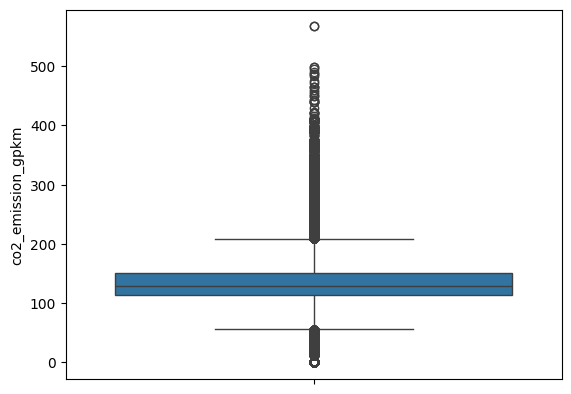

In [23]:
sns.boxplot(df["co2_emission_gpkm"])

In [63]:
new_df = df

lq = 0.25
uq = 0.75

for col in cont_cols:
    if col == "advert_quality": # no outliers in a 0-100 percentage, so skip
        continue

    print("Removing outliers from '" + col + "' column")

    if("date" not in col):
        new_df[col] = new_df[col].astype('float')
    # calculate IQR for column Height
    q1 = new_df[col].quantile(lq)
    q3 = new_df[col].quantile(uq)
    iqr = q3 - q1

    # identify outliers
    threshold = 1.5
    outliers = new_df[(new_df[col] < q1 - threshold * iqr) | (new_df[col] > q3 + threshold * iqr)]

    new_df = new_df.drop(outliers.index)
    print(f"Removed {len(outliers)} outliers from df")
    

Removing outliers from 'first_retailer_asking_price' column
Removed 6248 outliers from df
Removing outliers from 'last_retailer_asking_price' column
Removed 1362 outliers from df
Removing outliers from 'reviews_per_100_advertised_stock_last_12_months' column
Removed 8382 outliers from df
Removing outliers from 'co2_emission_gpkm' column
Removed 5200 outliers from df
Removing outliers from 'top_speed_mph' column
Removed 284 outliers from df
Removing outliers from 'engine_power_bhp' column
Removed 5914 outliers from df
Removing outliers from 'fuel_economy_wltp_combined_mpg' column
Removed 1887 outliers from df
Removing outliers from 'number_of_images' column
Removed 2732 outliers from df
Removing outliers from 'predicted_mileage' column
Removed 520 outliers from df
Removing outliers from 'adjusted_retail_amount_gbp' column
Removed 831 outliers from df
Removing outliers from 'first_registration_date' column
Removed 0 outliers from df
Removing outliers from 'odometer_reading_miles' column


<Axes: ylabel='number_of_images'>

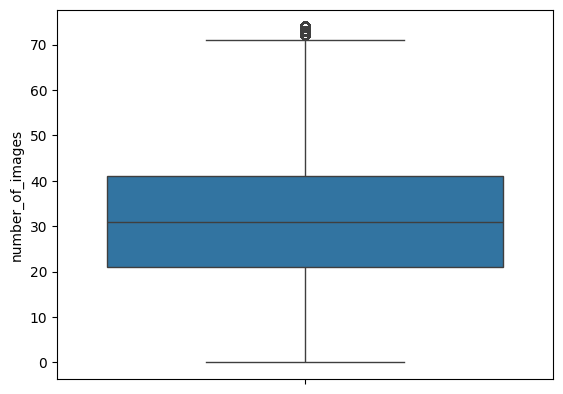

In [58]:
sns.boxplot(new_df["number_of_images"])